<a href="https://colab.research.google.com/github/Singara-Harendra/Solar-Panel-Defect-Detection-Using-Streamlit/blob/main/Solar_Panel_Defect_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow --upgrade

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import json
from google.colab import drive
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
CONFIG = {
    "data_dir": "/content/drive/MyDrive/Collab datasets/combined_shuffled",
    "img_size": (224, 224),
    "batch_size": 32,
    "epochs": 15,
    "class_names": ['Clean', 'Electrical-damage', 'Physical-Damage', 'Bird-drop', 'Dusty', 'Snow-Covered'],
    "save_dir": "/content/drive/MyDrive/solar_model",
    "learning_rate": 0.0001,
    "validation_split": 0.2,
    "random_state": 42
}

os.makedirs(CONFIG["save_dir"], exist_ok=True)

In [18]:
def setup_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("✅ GPU configured successfully")
        except RuntimeError as e:
            print(e)

setup_gpu()

✅ GPU configured successfully


In [19]:
def extract_labels(image_paths):
    """Extracts class labels from filenames like 'classlabel_number_something.jpg'"""
    valid_paths = []
    labels = []

    for path in image_paths:
        try:
            filename = os.path.basename(path)
            # Split filename into parts (e.g., ["Crack", "123", "abc.jpg"])
            parts = filename.split('_')

            # The FIRST part is always the class label (e.g., "Crack")
            class_name = parts[0]

            # Validate against known classes
            if class_name in CONFIG["class_names"]:
                labels.append(class_name)
                valid_paths.append(path)
            else:
                print(f"⚠️ Unknown class '{class_name}' in file: {filename}")
        except Exception as e:
            print(f"⛔ Skipping {path}: {str(e)}")

    return np.array(valid_paths), np.array(labels)

In [20]:
def prepare_dataset():
    print("🔍 Searching for images...")
    image_files = []
    for root, _, files in os.walk(CONFIG["data_dir"]):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, file))

    image_paths, labels = extract_labels(image_files)

    if len(image_paths) == 0:
        raise ValueError("❌ No valid images found!")

    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)

    return train_test_split(
        image_paths, encoded_labels,
        test_size=CONFIG["validation_split"],
        random_state=CONFIG["random_state"],
        stratify=encoded_labels
    ), le

In [21]:
def create_data_pipeline(paths, labels, augment=False):
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, CONFIG["img_size"])
        img = tf.keras.applications.resnet50.preprocess_input(img)
        return img, label

    def augment_image(img, label):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.1)
        img = tf.image.random_contrast(img, 0.9, 1.1)
        return img, label

    dataset = tf.data.Dataset.from_tensor_slices((paths, labels))
    dataset = dataset.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset.batch(CONFIG["batch_size"]).prefetch(tf.data.AUTOTUNE)

In [22]:
def build_model():
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(*CONFIG["img_size"], 3)
    )
    base_model.trainable = False  # Freeze ResNet layers

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(len(CONFIG["class_names"]), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(CONFIG["learning_rate"]),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print("🛠️ Model built successfully!")
    return model

In [ ]:
def train():
    (train_paths, val_paths, train_labels, val_labels), label_encoder = prepare_dataset()

    # Print dataset stats
    print("\n📊 Dataset Summary:")
    print(f"→ Training samples: {len(train_paths)}")
    print(f"→ Validation samples: {len(val_paths)}")
    print("\n🏷️ Class Distribution:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"{class_name}: {np.sum(train_labels == i)} train | {np.sum(val_labels == i)} val")

    train_ds = create_data_pipeline(train_paths, train_labels, augment=True)
    val_ds = create_data_pipeline(val_paths, val_labels)

    model = build_model()

    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint(
            filepath=os.path.join(CONFIG["save_dir"], "best_model.h5"),
            save_best_only=True,
            monitor='val_accuracy'
        )
    ]

    print("\n🚀 Starting training...")
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=CONFIG["epochs"],
        callbacks=callbacks
    )

    # Save everything
    model.save(os.path.join(CONFIG["save_dir"], 'final_model.h5'))
    np.save(os.path.join(CONFIG["save_dir"], 'label_encoder.npy'), label_encoder.classes_)
    with open(os.path.join(CONFIG["save_dir"], 'config.json'), 'w') as f:
        json.dump(CONFIG, f)

    print(f"\n🎉 Training complete! Model saved to {CONFIG['save_dir']}")
    return history

history = train()

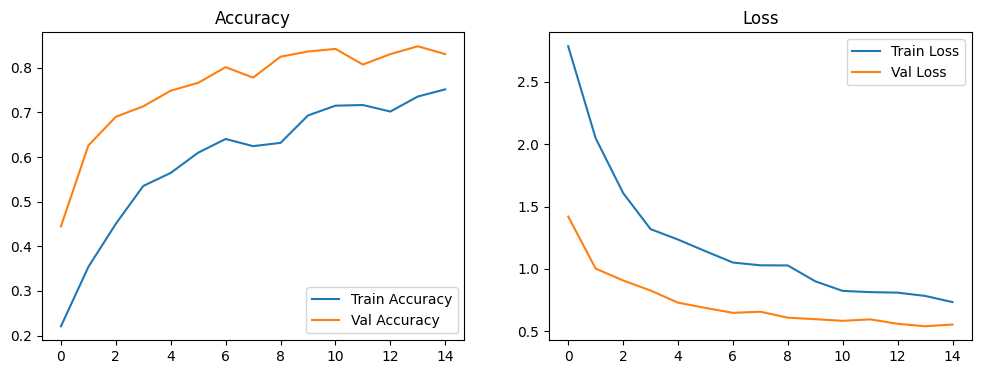

In [36]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)

In [38]:
# Get the final epoch's accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.2%}")
print(f"Final Validation Accuracy: {final_val_acc:.2%}")

Final Training Accuracy: 75.15%
Final Validation Accuracy: 83.04%
